# Step 9: Scaling Up.

In the previous section we experimented on a dataset that only had 5 flowers. Now let's try to see how our model performs on bigger datasets.


## Prediction
I predict we will run into the following difficulties:
 * Needing to re-tune model hyper-parameters to work with more classes. We may even need to swap out the base model for a bigger net.
 * Time to train model will go up. Maybe we need a way to checkpoint our work to disk and run multiple times, or maybe even move to a cloud solution.
 
 Let's see how it goes :) 


In [10]:
import pathlib
import os.path

import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorboard.plugins.hparams import api as hp

In [11]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [12]:
model_url = 'https://tfhub.dev/google/bit/s-r101x1/1'
base_model = hub.KerasLayer(model_url)

In [13]:
batch_size = 32
epochs=25
img_height = 100
img_width = 100

In [14]:
# Let's define a function for reading our data, since we do it more than once.
def read_data(flower_set):
    data_dir =  pathlib.Path(os.path.abspath("images/" + flower_set + '/'))
    return tf.keras.utils.image_dataset_from_directory(data_dir, validation_split=0.2, subset="both", seed=123,
                                                               image_size=(img_height, img_width), batch_size=batch_size)

In [15]:
from sklearn.metrics import f1_score as sk_f1

# Define our own function since we are working with batch datasets.
def f1_score(model, val_ds):
    y_pred = []  # store predicted labels
    y_true = []  # store true labels

    # We iterate over the dataset to get the true label and input at the same time.
    # Otherwise we will unintentionally shuffle the dataset.
    for image_batch, label_batch in val_ds:
        y_true.append(label_batch)
        preds = model.predict(image_batch, verbose=0)
        y_pred.append(np.argmax(preds, axis = - 1))

    # convert the true and predicted labels into tensors
    correct_labels = tf.concat([item for item in y_true], axis = 0)
    predicted_labels = tf.concat([item for item in y_pred], axis = 0)
    
    return sk_f1(correct_labels, predicted_labels, average=None)

## 9.1: Datasets

So far we have been testing our dataset on only 5 flowers. Now let's try scaling it up.

Sets:

| name | size | reason
|------|------|------
|Flowers5| 1,857 | **Prototype set** can iterate quickly on it.
|Flowers15 | 5,902 | **Test scaling** this medium sized set will tell us how increasing the scale impacts our model.
|Flowers41 | 15,329 | **Target**. Meets the minimum requirement of 15,000 files.
|Flowers299 | 115,944 | **Stretch**. Very large set, could be interesting to build a model on this if time allows.

In [23]:
train5_ds, val5_ds = read_data('Flowers5')
print(train5_ds.class_names)

Found 1857 files belonging to 5 classes.
Using 1486 files for training.
Using 371 files for validation.
['Calceolaria', 'Daffodil', 'Freesia', 'Hibiscus', 'Iris']


In [21]:
train15_ds, val15_ds = read_data('Flowers15')
print(train15_ds.class_names)

Found 5902 files belonging to 15 classes.
Using 4722 files for training.
Using 1180 files for validation.
['Abutilon', "Baby'sBreath", 'Calceolaria', 'Celosia', 'Daffodil', 'Epimedium', 'Erica', 'FrangipaniFlower', 'Freesia', 'FrenchMarigold', 'Hibiscus', 'Hyacinth', 'IpomoeaLobata', 'Iris', 'JohnnyJumpUp']


In [25]:
train41_ds, val41_ds = read_data('Flowers41')
print(train41_ds.class_names)

Found 15329 files belonging to 41 classes.
Using 12264 files for training.
Using 3065 files for validation.
['Abutilon', 'Acacia', 'Alyssum', "Baby'sBreath", 'Bellflower', 'BleedingHeart', 'Borage', 'Buttercup', 'Calceolaria', 'Celosia', 'Chrysanthemum', 'Clover', 'Crocus', 'Daffodil', 'Daisy', 'Dandelion', 'Diascia', 'Dill', 'Epimedium', 'Erica', 'FrangipaniFlower', 'Freesia', 'FrenchMarigold', 'Fuchsia', 'Gardenia', 'Gladiolas', 'Hibiscus', 'Honeysuckle', 'Hyacinth', 'IpomoeaLobata', 'Iris', 'JacobsLadder', 'Jasmine', 'JohnnyJumpUp', 'Lily', 'Lotus', 'Magnolia', 'Marigold', 'Orchid', 'Roses', 'TobaccoPlant']


In [26]:
train299_ds, val299_ds = read_data('Flowers299')
print(train299_ds.class_names)

Found 115944 files belonging to 299 classes.
Using 92756 files for training.
Using 23188 files for validation.
['Abutilon', 'Acacia', 'Aconite', 'AfricanDaisy', 'Agapanthus', 'Ageratum', 'Alchemilla', 'Allium', 'Alstroemeria', 'Alyssum', 'Amaranthus', 'Amaryllis', 'Anemone', 'AniseHyssop', 'ArmeriaMaritima', 'Aster', 'Azalea', "Baby'sBreath", "Bachelor'sButton", 'BalloonFlower', 'Ballota', 'BeeBalm', 'Begonia', 'Bellflower', 'Bergamot', 'Bergenia', 'Billbergia', 'Black-eyedSusan', 'BlanketFlower', 'BlazingStar', 'BleedingHeart', 'Bletilla', 'Blue-eyedGrass', 'Bluebonnets', 'BluestarFlower', 'Borage', 'Bottlebrush', 'Bouvardia', 'Brachyscome', 'Brassica', 'Broom', 'Buttercup', 'ButterflyBush', 'Calceolaria', 'Calendula', 'CaliforniaPoppy', 'CallaLily', 'Camellia', 'Candytuft', 'CannaLily', 'CapeLeadwort', 'CapePrimrose', 'CardinalFlower', 'Carnation', 'Catharanthus', 'Catmint', 'Celosia', 'CerastiumTomentosum', 'Chicory', 'Chionodoxa', 'Chrysanthemum', 'Clarkia', 'Clematis', 'Clover', '

## 9.2: Scaling up to 15 flowers.

### 9.2.1: Run the top model for 5 flowers.
In the previous section we built a prototype on 5 flowers that achieved an accuracy of 95% with an F1 score of 0.95. Let's start by seeing how well that model works on the 15 set.

In [ ]:
model_15 = tf.keras.Sequential([
    layers.Rescaling(1./255), base_model, layers.Flatten(), layers.Dense(16, activation='relu'), layers.Dropout(0.25),
    layers.Dense(len(train15_ds.class_names)),
])
model_15.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

history = model_15.fit(train15_ds, validation_data=val15_ds, epochs=epochs, verbose=1)

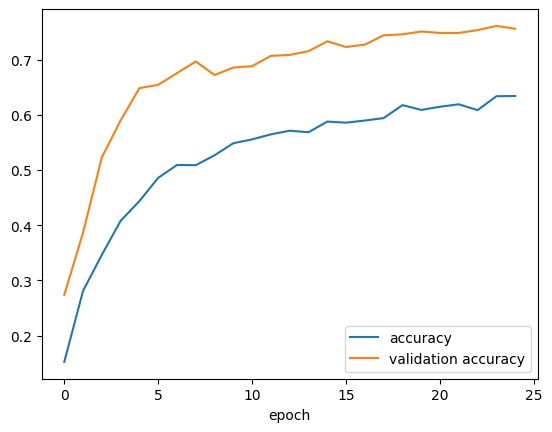

In [54]:
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.legend()
plt.xlabel('epoch')
plt.show()

In [39]:
f1 = f1_score(model_15, val15_ds)
print("F1 score:", np.mean(f1))

F1 score: 0.7520246286921581



**Results**: Our model seems to be underfitted, and does not perform nearly as well on this dataset. We likely need to re-tune it. I suspect we need a denser layer.

### 9.2.2: Re-tuning our model.

Let's see if changing the density and dropout will improve our model.

In [16]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([16, 32, 48, 64, 80, 96, 112, 128]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.3))

METRIC_F1_SCORE = 'f1_score'
DIR='logs/hparam_tuning'

with tf.summary.create_file_writer(DIR).as_default():
    hp.hparams_config(
        hparams=[HP_NUM_UNITS, HP_DROPOUT],
        metrics=[hp.Metric(METRIC_F1_SCORE, display_name='F1 Score')],
    )

In [18]:
def train_test_model(hparams, num_classes, train_ds, val_ds):
    model = tf.keras.Sequential([
        layers.Rescaling(1./255),
        base_model,
        layers.Flatten(),
        layers.Dense(hparams[HP_NUM_UNITS], activation='relu'),
        layers.Dropout(hparams[HP_DROPOUT]),
        layers.Dense(num_classes),
    ])
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

    model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=1)
    
    f1 = f1_score(model, val_ds)
    print("f1:", f1)
    return np.mean(f1)

In [19]:
def run(run_dir, hparams, train_ds, val_ds):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        f1 = train_test_model(hparams, len(train_ds.class_names), train_ds, val_ds)
        tf.summary.scalar(METRIC_F1_SCORE, f1, step=1)

In [ ]:
session_num = 22
for num_units in HP_NUM_UNITS.domain.values:
    for dropout_rate in np.linspace(HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value, num=3):
        hparams = {HP_NUM_UNITS: num_units, HP_DROPOUT: dropout_rate}
        run_name = "run-flowers15-%d" % session_num
        print('--- Starting trial: %s' % run_name)
        print({h.name: hparams[h] for h in hparams})
        run(DIR + '/' + run_name, hparams, train15_ds, val15_ds)
        session_num += 1

In [ ]:
%tensorboard --logdir logs/hparam_tuning --host localhost

![Tensorboard](step9-15flowers-2.png) ![Tensorboard](step9-15flowers-1.png)

Making out model wider did improve it, but we only got an F1 score of 0.91. Not as good as the 0.95 we got before.